In [1]:
import matplotlib.pyplot as plt
import os
import time
import webbrowser

In [2]:
%matplotlib inline

In [3]:
import pandas as pd

In [4]:
from PIL import Image

In [5]:
kilburn = (51.541882,-0.1979358)
grove = (51.4318969,0.0212344)

## Task 1 - Find a way to gather data between specific lat, long coordinate pairs

In [6]:
def get_data_in_grid(topleft, bottomright, months=None, categories=None):
    '''
    topleft and bottomright are both tuples of (latidude, longitude) pairs
    
    month should be either be None for whole year or list of ints
    
    catagories : list (case insensitive)
                {['Anti-social behaviour', 'Criminal damage and arson',
               'Shoplifting', 'Violence and sexual offences', 'Other crime',
               'Burglary', 'Public order', 'Other theft', 'Bicycle theft',
               'Possession of weapons', 'Vehicle crime', 'Drugs',
               'Theft from the person', 'Robbery']}
    '''
    
    def between_limits(x, upper, lower):
        '''Helper function for determining whether given coords are within a range'''
        if lower <= x <= upper:
            return True
        else:
            return False
    
    all_files = [os.path.join(root, file) for root, dirs, files in os.walk('data') for file in files]
    
    if months:
        strings = [f'2019-{month:02}' for month in months]        
        files = [file for file in all_files if any(x in file for x in strings)]        
    else:
        files = all_files
    
    ## initialise empty dataframe
    dataframe = pd.DataFrame()
    for file in files:                       
        df = pd.read_csv(file)
        df.dropna(how='any', subset=['Latitude','Longitude'], inplace=True)
        
        if categories:            
            ## the following line of code didn't work for a) lists of categories and b) lambda
            ## could not access the category argument given to the main function
            ## df = df[df['Crime type'].apply(lambda x: category in x.lower())]

            match_string = '|'.join(c for c in categories)
            df= df[df['Crime type'].str.contains(match_string, case=False)]
        
        ## find the rows with lat and long within bounds of TOPLEFT and TOPRIGHT
        
        ## LAT
        lat_limits = (topleft[0], bottomright[0])
        max_lat = max(lat_limits)
        min_lat = min(lat_limits)
        
        df = df[df['Latitude'].apply(between_limits, args=(max_lat, min_lat))]
        
        ## df = df[df['Latitude'].apply(lambda x: min_lat <= x <= max_lat)]
        ## solution to the problem is above. problem: lambda seems to not be able to access
        ## other vars in scope of main function
                            
        ## LONG
        long_limits = (topleft[1], bottomright[1])
        max_long = max(long_limits)
        min_long = min(long_limits)
        
        df = df[df['Longitude'].apply(between_limits, args=(max_long, min_long))]
        
        ## only concat if df.length > 0
        if len(df) > 0:
            plural = 's' if len(df) > 1 else ''
            print(f'Collecting {len(df)} row{plural} from {file}')
            dataframe = pd.concat([dataframe, df])
    
    return dataframe

The above function actually took much longer than expected to write. Should learn abut debugging in jupyter notebook

In [7]:
df = get_data_in_grid(kilburn, grove, months=[1,2,3,4,5,6], categories=['violence','drug'])

# Task 2 - Source map image

In [8]:
def get_map_image(topleft, bottomright, download=False):
    min_x = min(topleft[1], bottomright[1])
    min_y = min(topleft[0], bottomright[0])
    max_x = max(topleft[1], bottomright[1])
    max_y = max(topleft[0], bottomright[0])
    url = f'https://render.openstreetmap.org/cgi-bin/export?bbox={min_x},{min_y},{max_x},{max_y}&scale=50000&format=png'
    if download:
        webbrowser.open(url)
    return (min_x, max_x, min_y, max_y), url

#### get_map_image() was working yesterday!? Invalid or missing token now... :/

In [20]:
bbox, url = get_map_image(kilburn, grove, download=True)

In [21]:
london = Image.open('./images/kilburn.png')

In [22]:
def get_rect(topleft, botright):
    coords = []
    coords.append(topleft)
    coords.append(botright)
    
    width = botright[1] - topleft[1]
    height = botright[0] - topleft[0]
       
    topright = [topleft[0], botright[1]]
    coords.append(topright)
    
    botleft = [botright[0], topleft[1]]
    coords.append(botleft)
    
    return coords

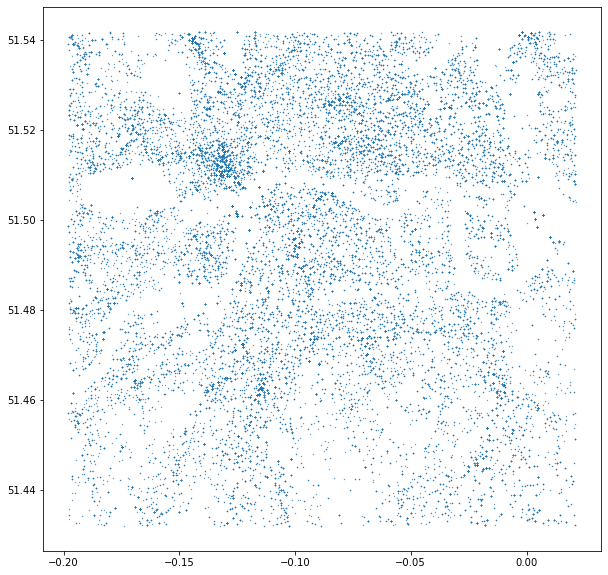

In [23]:
## lets plot a scatter of Latitude vs Longitude. You can see the river Thames
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(df.Longitude, df.Latitude, s=.1)

In [24]:
bbox, url

((-0.1979358, 0.0212344, 51.4318969, 51.541882),
 'https://render.openstreetmap.org/cgi-bin/export?bbox=-0.1979358,51.4318969,0.0212344,51.541882&scale=50000&format=png')

In [25]:
def map_scatter(map_image, dataframe, bbox, alpha, size):
    fig = plt.figure()

    ax = fig.add_axes([0,0,1,1])

    ax.set_xlim(bbox[0], bbox[1])
    ax.set_ylim(bbox[2], bbox[3])

    ax.imshow(map_image, zorder=0, extent=bbox, aspect='auto') # extent=box

    ax.scatter(dataframe.Longitude, dataframe.Latitude, zorder=1, marker='*', color='black', alpha=alpha, s=size)


    
def map_histogram(map_image, dataframe, bbox, bins):
    fig = plt.figure()

    ax = fig.add_axes([0,0,1,1])

    ax.set_xlim(bbox[0], bbox[1])
    ax.set_ylim(bbox[2], bbox[3])

    ax.imshow(map_image, zorder=0, extent=bbox, aspect='auto', alpha=1) # extent=box
    counts, xedges, yedges, image = ax.hist2d(dataframe.Longitude, dataframe.Latitude, 
                                              bins=bins,
                                              color='red',
                                              edgecolor='None',
                                              zorder=1,
                                              alpha=.5,
                                              cmap=plt.cm.Reds)

    plt.colorbar(image, ax=ax)

### Scatter plot of crimes on top of London map

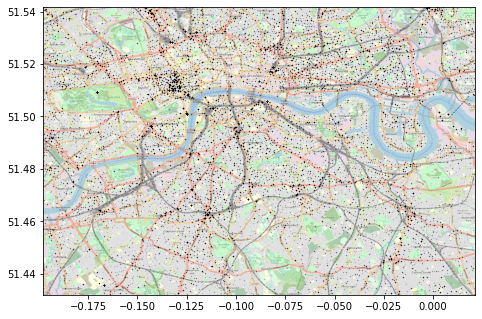

In [26]:
## add image
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])

ax.set_xlim(bbox[0], bbox[1])
ax.set_ylim(bbox[2], bbox[3])

ax.imshow(london, zorder=0, extent=bbox, aspect='auto') # extent=box

ax.scatter(df.Longitude, df.Latitude, zorder=1, marker='*', color='black', alpha=.1, s=0.2)


# ax.hist2d(df.Longitude, df.Latitude, zorder=1, alpha=.2, bins=50)## june


Scatter plot looks ok, not the best visualisation for distribution though.

#### There is an obvious clustering of crimes around Covent Garden, Fitzrovia and Mayfair

### Try a 2D Histogram

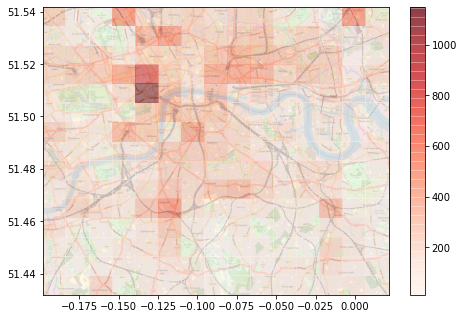

In [27]:
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])

ax.set_xlim(bbox[0], bbox[1])
ax.set_ylim(bbox[2], bbox[3])

ax.imshow(london, zorder=0, extent=bbox, aspect='auto', alpha=1) # extent=box
counts, xedges, yedges, image = ax.hist2d(df.Longitude, df.Latitude, 
                                          bins=(15),
                                          color='red',
                                          edgecolor='None',
                                          zorder=1,
                                          alpha=.5,
                                          cmap=plt.cm.Reds)

plt.colorbar(image, ax=ax)

### n.b. Map isn't that readable unfortunately. There must be a better way to show density on top of a map. Furthermore, the map might be better off in greyscale for clarity.

# Lets see where the most violent roads are in my neighbourhood #mallcop

#### 1. Gather our data

In [28]:
bow_TL = (51.533070, -0.041590)
bow_BR = (51.519524, -0.013315)

In [29]:
bow_crime = get_data_in_grid(bow_TL, bow_BR, categories=['violence'])

## 2. Download our map image

In [30]:
bbox, url = get_map_image(bow_TL, bow_BR)
url

'https://render.openstreetmap.org/cgi-bin/export?bbox=-0.04159,51.519524,-0.013315,51.53307&scale=50000&format=png'

In [31]:
bow = Image.open(r"C:\Users\tpjal\Downloads\map (2).png")

## 3. Plot scatter data onto map

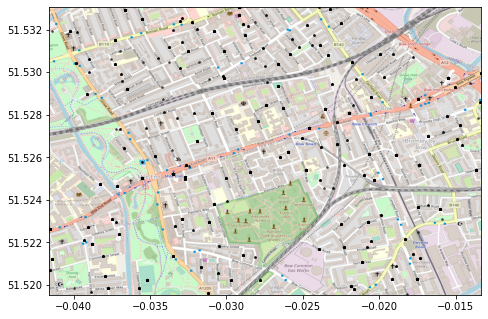

In [32]:
map_scatter(bow, bow_crime, bbox, alpha=.5, size=5)

## 4. Plot 2D Histogram

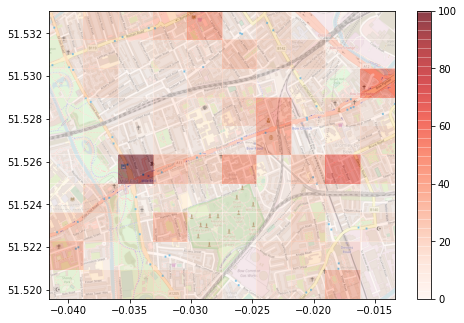

In [33]:
map_histogram(bow, bow_crime, bbox, bins=(10,10))

_______________________

#### --- Helper functions ---

In [ ]:
# address = driver.find_element_by_id('_location')

In [ ]:
boundary = get_rect(kilburn, grove)
boundary

In [ ]:
def plot_point(address_box, pair):
    address = driver.find_element_by_id('_location')
    stri = f'{pair[0]}, {pair[1]}\n'
    address.send_keys(stri)